Print top 10 tickers and all mentions in time series

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
ticker_mentions = pd.read_csv("ticker_mentions_combined_daily.csv")

# Show top mentioned tickers
top_tickers = (
    ticker_mentions.groupby("ticker")["total_mentions"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
print("🔝 Top 10 mentioned tickers:\n", top_tickers)

# Plot total mentions per day
mentions_per_day = ticker_mentions.groupby("date")["total_mentions"].sum()

plt.figure(figsize=(12, 5))
mentions_per_day.plot(title="📈 Total Ticker Mentions per Day", grid=True)
plt.xlabel("Date")
plt.ylabel("Mentions")
plt.tight_layout()
plt.show()



Find most volatile tickers

In [4]:
import pandas as pd

# Load the combined mentions dataset
df = pd.read_csv("ticker_mentions_combined_daily.csv")

# Group by ticker and get daily mention stats
iqr_stats = (
    df.groupby("ticker")["total_mentions"]
    .agg(Q1=lambda x: x.quantile(0.15),
         Q3=lambda x: x.quantile(0.85))
    .reset_index()
)

# Calculate IQR (volatility)
iqr_stats["IQR"] = iqr_stats["Q3"] - iqr_stats["Q1"]

# Sort by most volatile tickers
most_volatile = iqr_stats.sort_values("IQR", ascending=False).head(20)

print("🔥 Top 20 most volatile tickers by IQR (mention spikes):")
print(most_volatile[["ticker", "IQR"]])


🔥 Top 20 most volatile tickers by IQR (mention spikes):
   ticker    IQR
64   NVDA  46.15
86   TSLA  22.00
27    DJT   8.90
0    AAPL   8.00
51   LUNR   7.00
1    ACHR   6.30
58   MSTR   6.00
75   RKLB   6.00
81   SMCI   5.90
5     AMD   5.70
7    ASTS   5.00
25    CVI   5.00
6    AMZN   5.00
57   MSFT   4.00
9      BA   4.00
67   PLTR   4.00
85    TGT   4.00
61   NDAQ   4.00
24   CRWD   3.25
72   QTWO   3.00


Count for a specific ticker

/var/folders/zn/s6zzv27j6jxfgw75rmyw03_r0000gn/T/ipykernel_28394/4212459231.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvda_mentions["date"] = pd.to_datetime(nvda_mentions["date"])


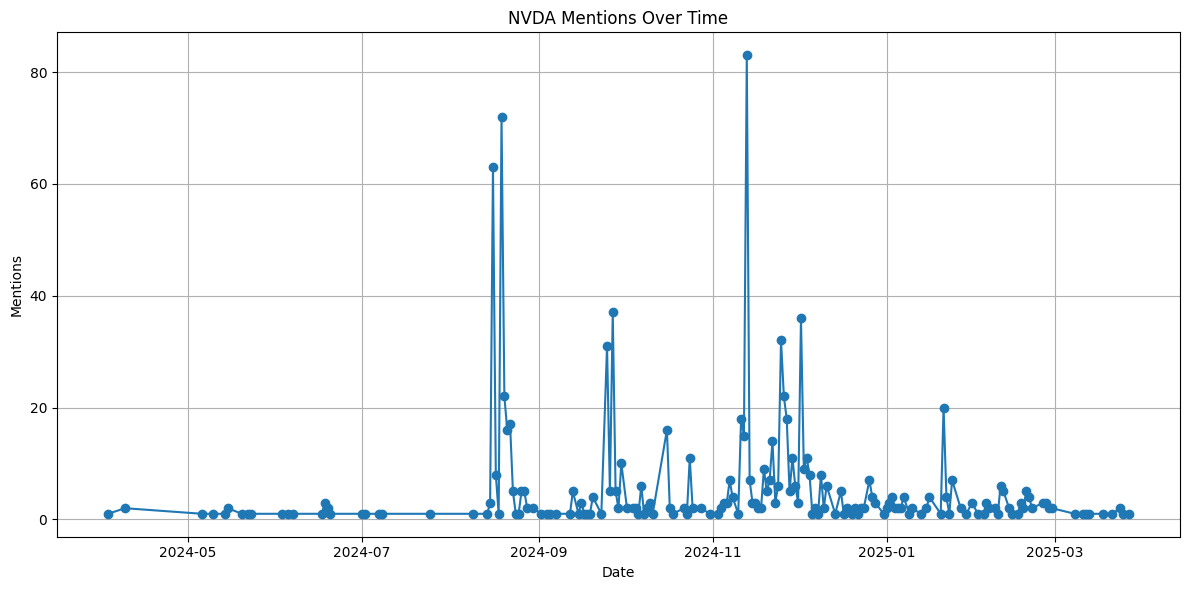

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the combined mentions CSV
df = pd.read_csv("ticker_mentions_combined_daily.csv")

# Filter for NVDA only
nvda_mentions = df[df["ticker"] == "RKLB"]

# Ensure the 'date' column is datetime
nvda_mentions["date"] = pd.to_datetime(nvda_mentions["date"])

# Sort by date just in case
nvda_mentions = nvda_mentions.sort_values("date")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(nvda_mentions["date"], nvda_mentions["total_mentions"], marker="o", linestyle="-")
plt.title("NVDA Mentions Over Time")
plt.xlabel("Date")
plt.ylabel("Mentions")
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
import pandas as pd

# --- Config ---
TICKER = "RKLB"  # ← Change this to any ticker you want

# Load the combined mentions CSV
df = pd.read_csv("ticker_mentions_combined_daily.csv")

# Filter for the selected ticker
ticker_mentions = df[df["ticker"] == TICKER.upper()]

# Sort by total_mentions in descending order and get top 10
top_10_days = ticker_mentions.sort_values("total_mentions", ascending=False).head(10)

# Display results
print(f"📈 Top 10 Days with Most {TICKER.upper()} Mentions:")
print(top_10_days[["date", "total_mentions"]])

📈 Top 10 Days with Most RKLB Mentions:
             date  total_mentions
8960   2024-11-13              83
5578   2024-08-19              72
5468   2024-08-16              63
7116   2024-09-27              37
9804   2024-12-02              36
9498   2024-11-25              32
7026   2024-09-25              31
9564   2024-11-26              22
5625   2024-08-20              22
11762  2025-01-21              20


Correlation between volatility and mentions

                total_mentions  daily_return
total_mentions        1.000000      0.120753
daily_return          0.120753      1.000000


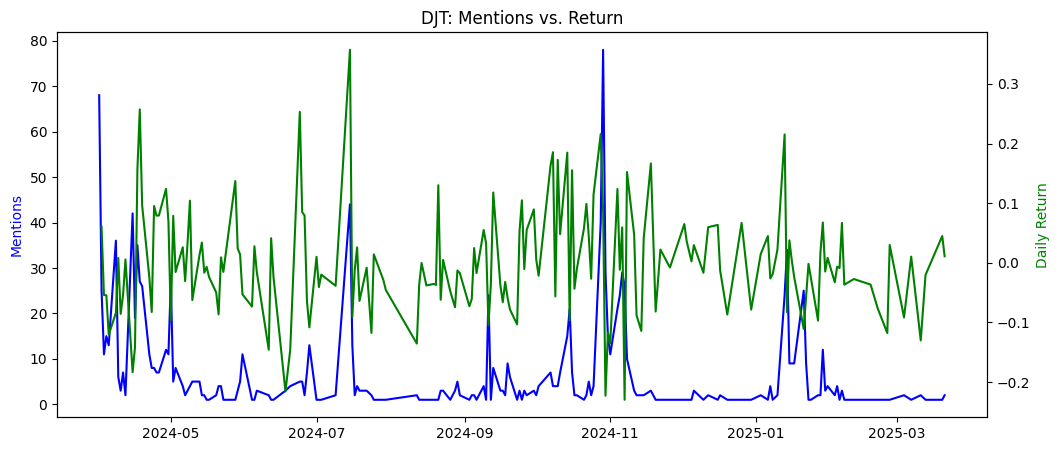

In [12]:
# Load data
mentions = pd.read_csv("ticker_mentions_combined_daily.csv", parse_dates=["date"])
prices = pd.read_csv("valid_tickers_closing_prices.csv", parse_dates=["Date"])
prices = prices.rename(columns={"Date": "date"})

# Example for NVDA
ticker = "DJT"
mentions_nvda = mentions[mentions["ticker"] == ticker][["date", "total_mentions"]]
price_nvda = prices[["date", ticker]].dropna()

# Merge
df = pd.merge(mentions_nvda, price_nvda, on="date")
df["daily_return"] = df[ticker].pct_change()

# Correlation
print(df[["total_mentions", "daily_return"]].corr())

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["total_mentions"], label="Mentions", color="blue")
plt.ylabel("Mentions", color="blue")
plt.twinx()
plt.plot(df["date"], df["daily_return"], label="Daily Return", color="green")
plt.ylabel("Daily Return", color="green")
plt.title(f"{ticker}: Mentions vs. Return")
plt.show()


In [14]:
# Find days with mention spikes (e.g., z-score)
from scipy.stats import zscore

df["mention_zscore"] = zscore(df["total_mentions"])
spike_days = df[df["mention_zscore"] > 2]
print(spike_days[["date", "total_mentions", "daily_return"]])


          date  total_mentions  daily_return
0   2024-04-01              68           NaN
5   2024-04-08              36     -0.084257
10  2024-04-15              42     -0.183492
12  2024-04-17              35      0.155867
60  2024-07-15              44      0.357191
120 2024-10-28              40      0.215918
121 2024-10-29              78      0.087627
156 2025-01-14              34     -0.082964


To movers by mention data

In [15]:
mentions_change = (
    mentions.groupby("ticker")["total_mentions"]
    .diff()
    .abs()
    .groupby(mentions["ticker"])
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

print("📈 Top tickers with highest average day-to-day change in mentions:")
print(mentions_change)


📈 Top tickers with highest average day-to-day change in mentions:
ticker
NVDA    17.314763
TSLA     9.986150
ACHR     6.724638
RKLB     5.804598
LUNR     5.698324
DJT      4.649573
ASTS     3.831683
AAPL     3.765244
CRWD     3.638095
SMCI     3.089744
Name: total_mentions, dtype: float64


                total_mentions  daily_volume
total_mentions         1.00000       0.85757
daily_volume           0.85757       1.00000


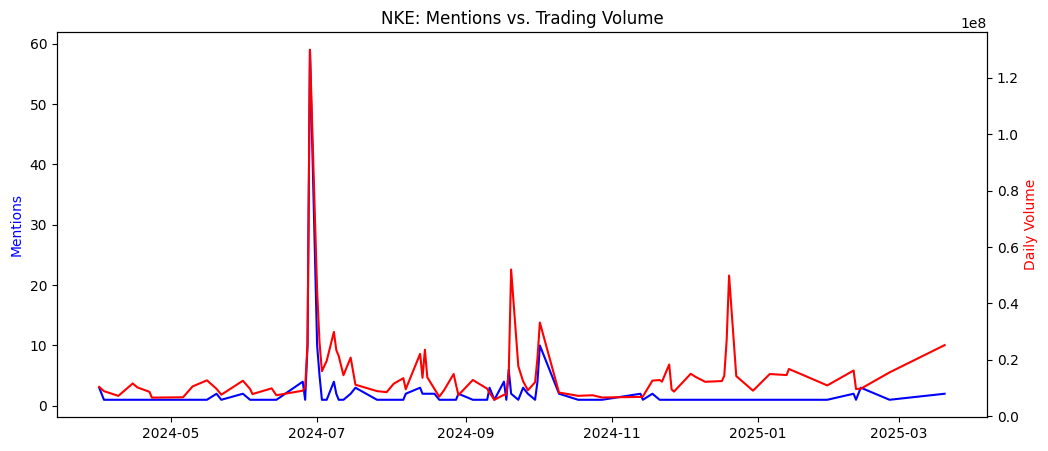

         date  total_mentions  daily_volume
20 2024-06-28              59     129967000


In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Load data
mentions = pd.read_csv("ticker_mentions_combined_daily.csv", parse_dates=["date"])
prices = pd.read_csv("valid_tickers_closing_prices.csv", parse_dates=["Date"])
volumes = pd.read_csv("valid_tickers_volumes.csv", parse_dates=["Date"])

# Rename dates to match
prices = prices.rename(columns={"Date": "date"})
volumes = volumes.rename(columns={"Date": "date"})

# Example for a single ticker
ticker = "NKE"  # you can change to any ticker you want
mentions_ticker = mentions[mentions["ticker"] == ticker][["date", "total_mentions"]]
volume_ticker = volumes[["date", ticker]].dropna()

# Merge
df = pd.merge(mentions_ticker, volume_ticker, on="date")
df = df.rename(columns={ticker: "daily_volume"})

# Correlation
print(df[["total_mentions", "daily_volume"]].corr())

# Plot
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["total_mentions"], label="Mentions", color="blue")
plt.ylabel("Mentions", color="blue")
plt.twinx()
plt.plot(df["date"], df["daily_volume"], label="Daily Volume", color="red")
plt.ylabel("Daily Volume", color="red")
plt.title(f"{ticker}: Mentions vs. Trading Volume")
plt.show()

# Find mention spike days (using z-score)
df["mention_zscore"] = zscore(df["total_mentions"])
spike_days = df[df["mention_zscore"] > 2]
print(spike_days[["date", "total_mentions", "daily_volume"]])


In [22]:
# CORRELATION between mentions and volume for all tickers

import pandas as pd

# Load your data
mentions = pd.read_csv("ticker_mentions_combined_daily.csv", parse_dates=["date"])
volumes = pd.read_csv("valid_tickers_volumes.csv", parse_dates=["Date"])
volumes = volumes.rename(columns={"Date": "date"})

# Find unique tickers
tickers = mentions["ticker"].unique()

# Empty list to collect results
correlation_results = []

for ticker in tickers:
    mentions_ticker = mentions[mentions["ticker"] == ticker][["date", "total_mentions"]]
    if ticker not in volumes.columns:
        print(f"⚠️ Volume data missing for {ticker}")
        continue
    volume_ticker = volumes[["date", ticker]].dropna()

    # Merge
    df = pd.merge(mentions_ticker, volume_ticker, on="date")
    df = df.rename(columns={ticker: "daily_volume"})
    
    if len(df) > 5:  # avoid very small samples
        corr = df["total_mentions"].corr(df["daily_volume"])
        correlation_results.append({"ticker": ticker, "mention_volume_correlation": corr})

# Make into DataFrame
correlation_df = pd.DataFrame(correlation_results)

# Sort by correlation strength
correlation_df = correlation_df.sort_values(by="mention_volume_correlation", ascending=False)

# Show top
print(correlation_df.head(50))

# Save if you want
correlation_df.to_csv("mentions_vs_volume_correlation.csv", index=False)


   ticker  mention_volume_correlation
80   SBUX                    0.921106
62    CRM                    0.890598
2     AMC                    0.863002
29    NKE                    0.857570
26   MSTR                    0.839221
70   CELH                    0.820936
66   RKLB                    0.816242
78   ORCL                    0.810677
36   SMCI                    0.792105
33   RIVN                    0.732460
52     MU                    0.726864
69   SOUN                    0.724477
68   SNOW                    0.714713
24   META                    0.712990
5    ASTS                    0.701503
21    LLY                    0.695370
39   TSLA                    0.687530
22   LULU                    0.678222
20    JPM                    0.660797
23   LUNR                    0.653331
37   SOFI                    0.639633
28   NFLX                    0.630904
54   PLTR                    0.619947
56   PYPL                    0.618479
85   CAVA                    0.617127
81   CRWD   

In [7]:
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

# Load the data
df = pd.read_csv("final_stock_sentiment_dataset.csv", parse_dates=["date"])

# Focus on one ticker (e.g. AAPL)
df_aapl = df[df["ticker"] == "TSLA"].sort_values("date")

# Create FinBERT net score
df["net_finbert_score"] = (df["no_positive_bert_score"] - df["no_negative_bert_score"]) / (
    df["no_positive_bert_score"] + df["no_negative_bert_score"] + 1e-6
)

# Create daily return
df["daily_return"] = df["closing_price"].pct_change()

# Drop missing rows
df_granger = df[["daily_return", "avg_vader_score", "net_finbert_score"]].dropna()

# Test whether VADER sentiment Granger-causes returns
print("Granger causality: VADER -> Return")
grangercausalitytests(df_granger[["daily_return", "avg_vader_score"]], maxlag=5, verbose=True)

# Test whether FinBERT sentiment Granger-causes returns
print("\nGranger causality: FinBERT -> Return")
grangercausalitytests(df_granger[["daily_return", "net_finbert_score"]], maxlag=5, verbose=True)


Granger causality: VADER -> Return

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7181  , p=0.3968  , df_denom=10859, df_num=1
ssr based chi2 test:   chi2=0.7183  , p=0.3967  , df=1
likelihood ratio test: chi2=0.7183  , p=0.3967  , df=1
parameter F test:         F=0.7181  , p=0.3968  , df_denom=10859, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3621  , p=0.6962  , df_denom=10856, df_num=2
ssr based chi2 test:   chi2=0.7245  , p=0.6961  , df=2
likelihood ratio test: chi2=0.7245  , p=0.6961  , df=2
parameter F test:         F=0.3621  , p=0.6962  , df_denom=10856, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2480  , p=0.8628  , df_denom=10853, df_num=3
ssr based chi2 test:   chi2=0.7444  , p=0.8627  , df=3
likelihood ratio test: chi2=0.7443  , p=0.8627  , df=3
parameter F test:         F=0.2480  , p=0.8628  , df_denom=10853, df_num=3

Granger Causality
number of lags (no zero) 4
s

/Users/frederikboysen/Desktop/10. semester Speciale/speciale/.venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


ssr based F test:         F=0.6230  , p=0.6822  , df_denom=10847, df_num=5
ssr based chi2 test:   chi2=3.1183  , p=0.6818  , df=5
likelihood ratio test: chi2=3.1179  , p=0.6818  , df=5
parameter F test:         F=0.6230  , p=0.6822  , df_denom=10847, df_num=5

Granger causality: FinBERT -> Return

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5322  , p=0.4657  , df_denom=10859, df_num=1
ssr based chi2 test:   chi2=0.5323  , p=0.4656  , df=1
likelihood ratio test: chi2=0.5323  , p=0.4656  , df=1
parameter F test:         F=0.5322  , p=0.4657  , df_denom=10859, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2666  , p=0.7660  , df_denom=10856, df_num=2
ssr based chi2 test:   chi2=0.5335  , p=0.7659  , df=2
likelihood ratio test: chi2=0.5335  , p=0.7659  , df=2
parameter F test:         F=0.2666  , p=0.7660  , df_denom=10856, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2591  , p=0.85

/Users/frederikboysen/Desktop/10. semester Speciale/speciale/.venv/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (0.532171242891261, 0.46571118626295294, 10859.0, 1),
   'ssr_chi2test': (0.532318265059847, 0.46563384016422327, 1),
   'lrtest': (0.5323052217136137, 0.46563930561564437, 1),
   'params_ftest': (0.5321712428896332, 0.46571118626295294, 10859.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.266638758390989, 0.7659547304780051, 10856.0, 2),
   'ssr_chi2test': (0.5335231309661996, 0.7658556561206493, 2),
   'lrtest': (0.5335100273077842, 0.7658606738925438, 2),
   'params_ftest': (0.2666387583904241, 0.7659547304784665, 10856.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.2591092666695059, 0.8548799794593059, 10853.0, 3),
   'ssr_chi2test': (0.7778291631892106, 0.8547623207296169, 3),
   'lrtest': (0.7778013091738103, 0.854768963292397, 3),
   'params_ftest': (0.2591092666696854, 0.854879979458731, 10853.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0

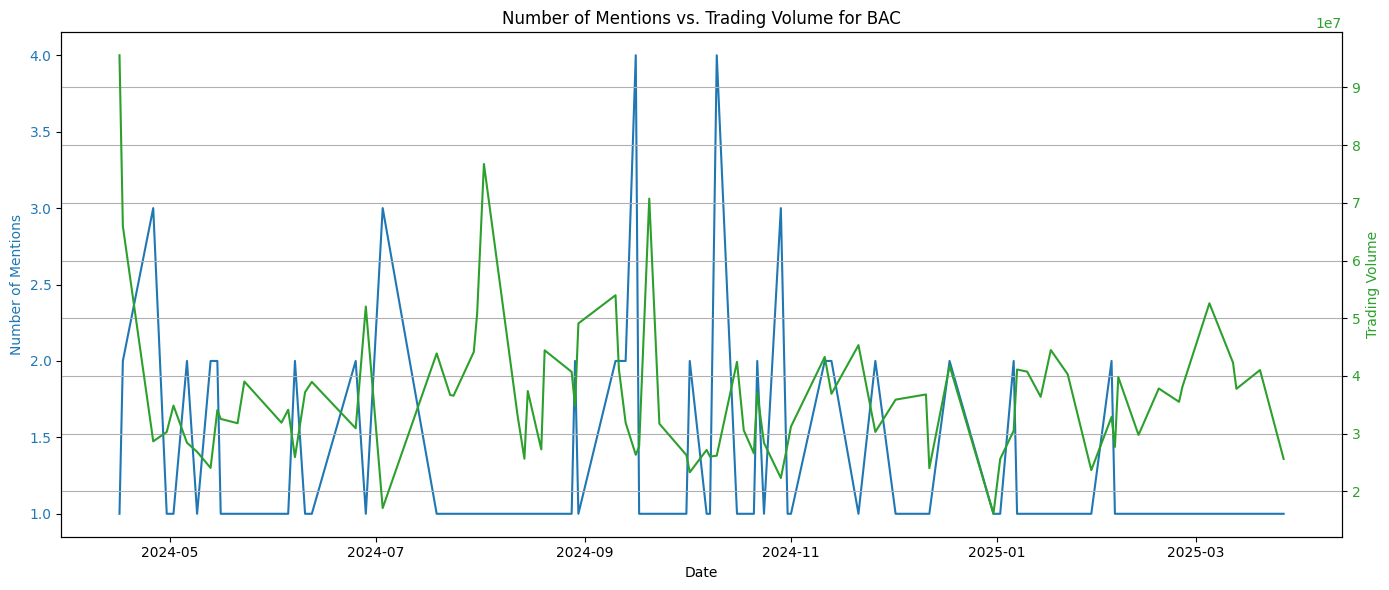

📈 Pearson correlation between mentions and volume for BAC: -0.217 (p = 0.04862579298383555571)


In [16]:
# Plot number_of_mentions and volume over time, and compare correlation

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load the data
df = pd.read_csv("final_stock_sentiment_dataset.csv", parse_dates=["date"])

# Choose a ticker (e.g., AAPL)
ticker = "BAC"
df_ticker = df[df["ticker"] == ticker].sort_values("date")

# Initialize figure and axis
fig, ax1 = plt.subplots(figsize=(14, 6))

# First y-axis: number of mentions
color1 = "tab:blue"
ax1.set_xlabel("Date")
ax1.set_ylabel("Number of Mentions", color=color1)
ax1.plot(df_ticker["date"], df_ticker["number_of_mentions"], color=color1, label="Number of Mentions")
ax1.tick_params(axis="y", labelcolor=color1)

# Second y-axis: trading volume
ax2 = ax1.twinx()
color2 = "tab:green"
ax2.set_ylabel("Trading Volume", color=color2)
ax2.plot(df_ticker["date"], df_ticker["volume"], color=color2, label="Trading Volume")
ax2.tick_params(axis="y", labelcolor=color2)

# Title and layout
plt.title(f"Number of Mentions vs. Trading Volume for {ticker}")
fig.tight_layout()
plt.grid(True)
plt.show()

# Correlation calculation
mentions = df_ticker["number_of_mentions"]
volume = df_ticker["volume"]
corr, pval = pearsonr(mentions, volume)

print(f"📈 Pearson correlation between mentions and volume for {ticker}: {corr:.3f} (p = {pval:.20f})")


In [15]:
import pandas as pd
from scipy.stats import pearsonr

# Load the data
df = pd.read_csv("final_stock_sentiment_dataset.csv", parse_dates=["date"])

# Initialize results list
results = []

# Loop through unique tickers
for ticker in df["ticker"].unique():
    df_ticker = df[df["ticker"] == ticker].sort_values("date")

    # Drop rows with missing data for correlation
    mentions = df_ticker["number_of_mentions"]
    volume = df_ticker["volume"]
    if mentions.isnull().any() or volume.isnull().any() or len(mentions) < 2:
        continue

    # Calculate Pearson correlation and p-value
    try:
        corr, pval = pearsonr(mentions, volume)
        results.append({
            "ticker": ticker,
            "correlation": corr,
            "p_value": pval
        })
    except Exception as e:
        print(f"Error with ticker {ticker}: {e}")

# Convert to DataFrame and sort
corr_df = pd.DataFrame(results).sort_values(by="correlation", ascending=False)

# Show results
print(corr_df)

# Optional: save to CSV
corr_df.to_csv("mention_volume_correlation_results.csv", index=False)


   ticker  correlation       p_value
79   SBUX     0.921106  5.372271e-44
62    CRM     0.890598  4.391967e-19
2     AMC     0.863002  9.974370e-29
29    NKE     0.857570  1.969605e-27
26   MSTR     0.839221  2.193232e-43
..    ...          ...           ...
44    BYD    -0.122650  3.463611e-01
17   HNST    -0.136566  1.548432e-01
61    BKE    -0.157183  1.872995e-01
86    FCF    -0.165069  1.819107e-01
85    BAC    -0.217143  4.862579e-02

[91 rows x 3 columns]


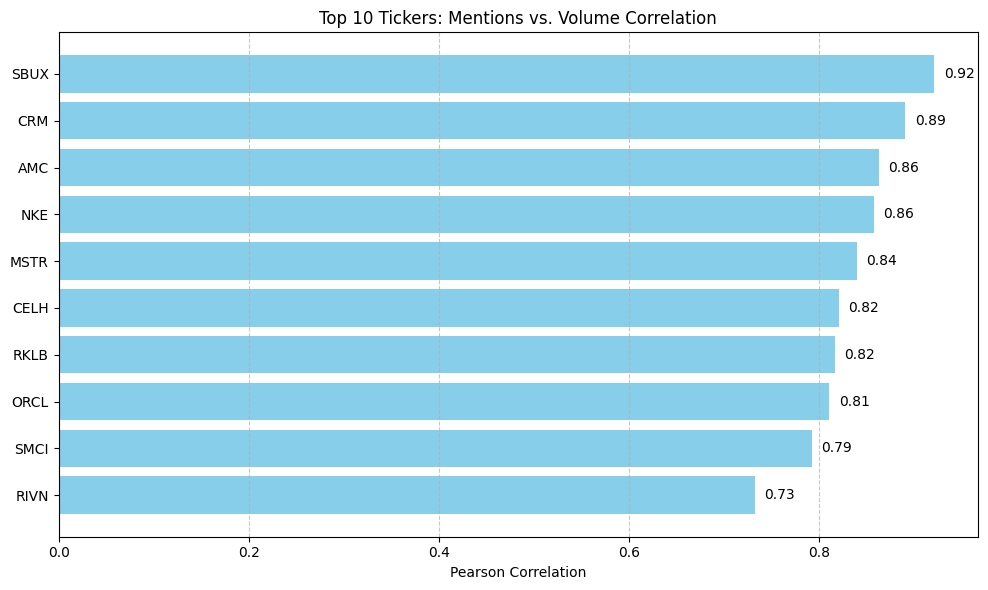

In [17]:
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("final_stock_sentiment_dataset.csv", parse_dates=["date"])

# Initialize results list
results = []

# Loop through all tickers
for ticker in df["ticker"].unique():
    df_ticker = df[df["ticker"] == ticker].sort_values("date")
    mentions = df_ticker["number_of_mentions"]
    volume = df_ticker["volume"]

    # Only include if data is valid
    if mentions.isnull().any() or volume.isnull().any() or len(mentions) < 2:
        continue

    try:
        corr, pval = pearsonr(mentions, volume)
        results.append({
            "ticker": ticker,
            "correlation": corr,
            "p_value": pval
        })
    except Exception as e:
        print(f"Skipping {ticker}: {e}")

# Create and sort DataFrame
corr_df = pd.DataFrame(results).sort_values(by="correlation", ascending=False)

# Plot top 10
top_n = 10
top_df = corr_df.head(top_n)

plt.figure(figsize=(10, 6))
bars = plt.barh(top_df["ticker"], top_df["correlation"], color="skyblue")
plt.xlabel("Pearson Correlation")
plt.title("Top 10 Tickers: Mentions vs. Volume Correlation")
plt.gca().invert_yaxis()  # Highest on top
plt.grid(axis="x", linestyle="--", alpha=0.7)

# Annotate bars with exact values
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}", va="center")

plt.tight_layout()
plt.show()


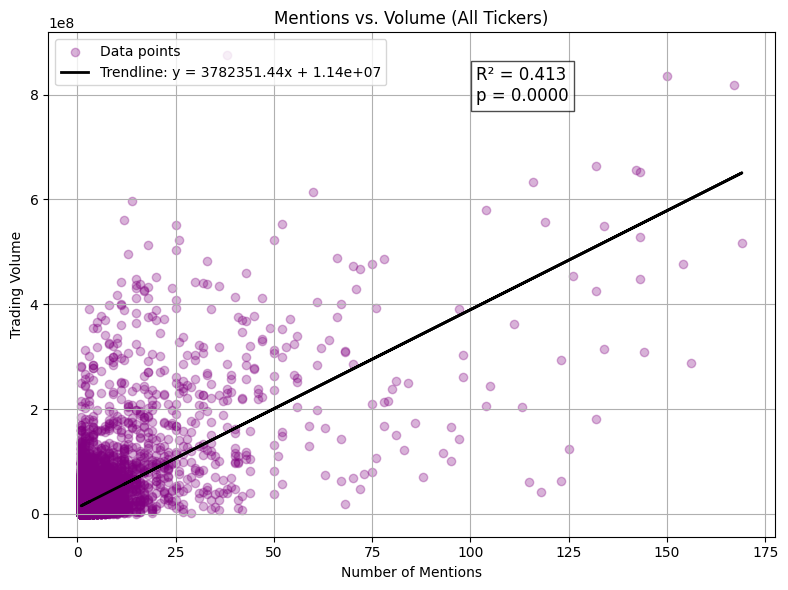

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Load the data
df = pd.read_csv("final_stock_sentiment_dataset.csv", parse_dates=["date"])

# Clean the data
df_clean = df.dropna(subset=["number_of_mentions", "volume"])
x = df_clean["number_of_mentions"]
y = df_clean["volume"]

# Linear regression (trendline)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
y_pred = p(x)

# R² calculation
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum((y - np.mean(y)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

# Pearson correlation p-value
corr, pval = pearsonr(x, y)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.3, color="purple", label="Data points")
plt.plot(x, y_pred, color="black", linewidth=2, label=f"Trendline: y = {z[0]:.2f}x + {z[1]:.2e}")
plt.xlabel("Number of Mentions")
plt.ylabel("Trading Volume")
plt.title("Mentions vs. Volume (All Tickers)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Annotate R² and p-value on the plot
plt.text(x.max() * 0.6, y.max() * 0.9,
         f"R² = {r_squared:.3f}\np = {pval:.4f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

plt.show()


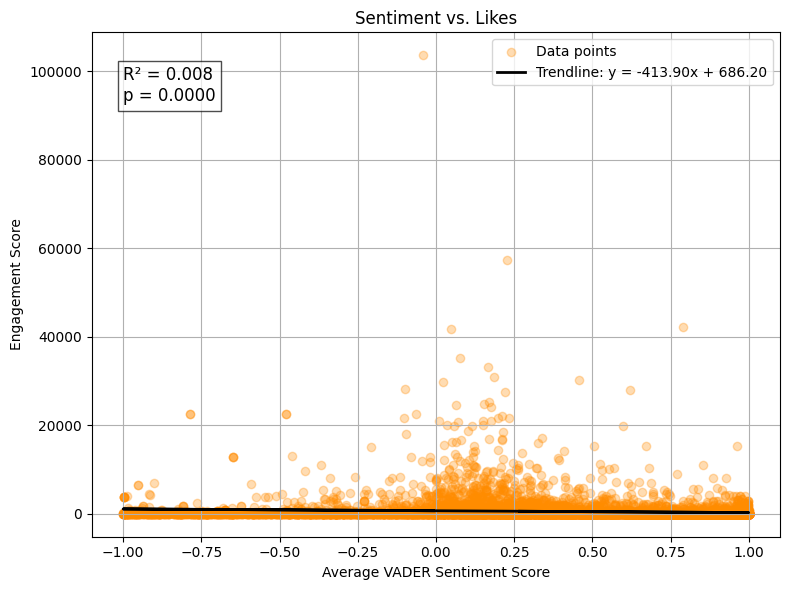

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Load data
df = pd.read_csv("final_stock_sentiment_dataset.csv", parse_dates=["date"])

# Drop missing values for required columns
df_clean = df.dropna(subset=["avg_vader_score", "like_score", "avg_num_comments"])

# Choose which engagement metric to analyze: "like_score" or "avg_num_comments"
engagement_metric = "like_score"  # or "avg_num_comments"

# X and Y for plotting
x = df_clean["avg_vader_score"]
y = df_clean[engagement_metric]

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.3, color="darkorange", label="Data points")

# Trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), color="black", linewidth=2, label=f"Trendline: y = {z[0]:.2f}x + {z[1]:.2f}")

# R²
y_pred = p(x)
r_squared = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)

# Correlation and p-value
corr, pval = pearsonr(x, y)

# Labels and annotation
plt.xlabel("Average VADER Sentiment Score")
plt.ylabel("Engagement Score" if engagement_metric == "like_score" else "Average Number of Comments")
plt.title(f"Sentiment vs. {'Likes' if engagement_metric == 'like_score' else 'Comments'}")
plt.text(x.min(), y.max()*0.9, f"R² = {r_squared:.3f}\np = {pval:.4f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


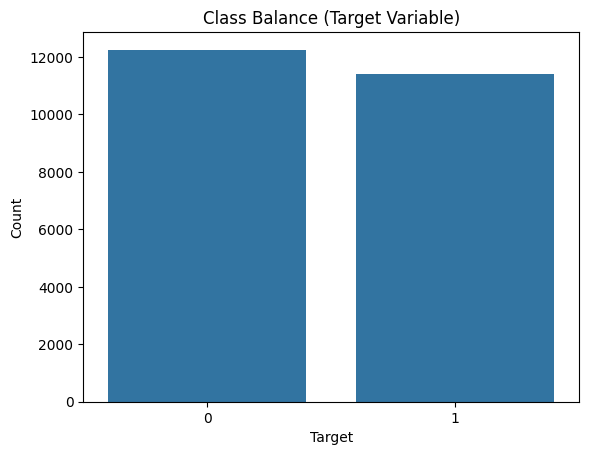

target
0    0.517878
1    0.482122
Name: proportion, dtype: float64
target
0    12253
1    11407
Name: count, dtype: int64


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df = pd.read_csv("final_stock_sentiment_dataset2.csv")

# Count plot
sns.countplot(data=df, x='target')
plt.title("Class Balance (Target Variable)")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

# Show value counts
print(df['target'].value_counts(normalize=True))
print(df['target'].value_counts())


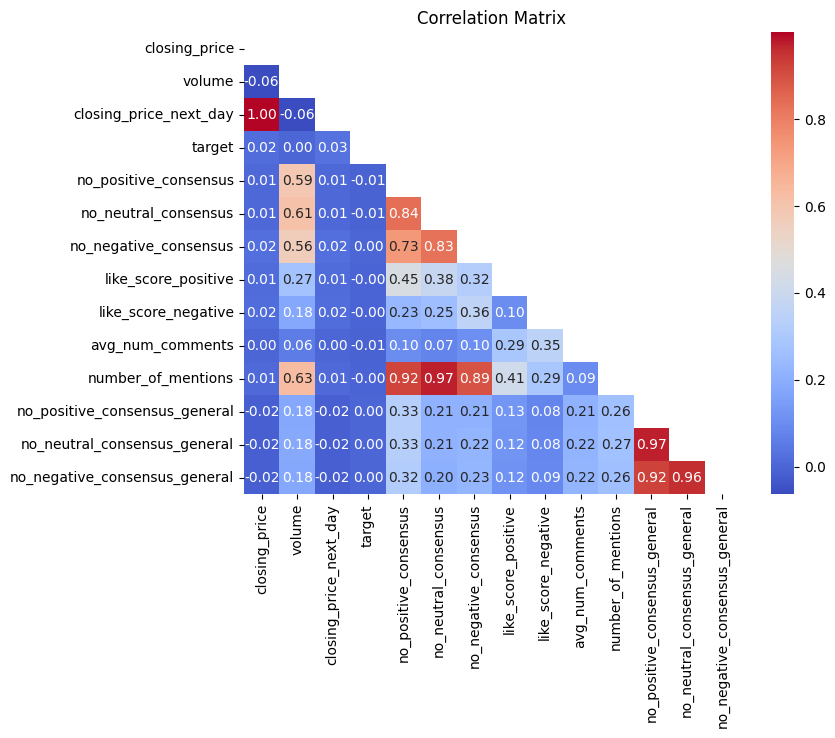

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df = pd.read_csv("final_stock_sentiment_dataset2.csv")

# Drop non-numeric columns for correlation
numeric_cols = df.select_dtypes(include='number')
corr = numeric_cols.corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", mask=np.triu(corr))
plt.title("Correlation Matrix")
plt.show()


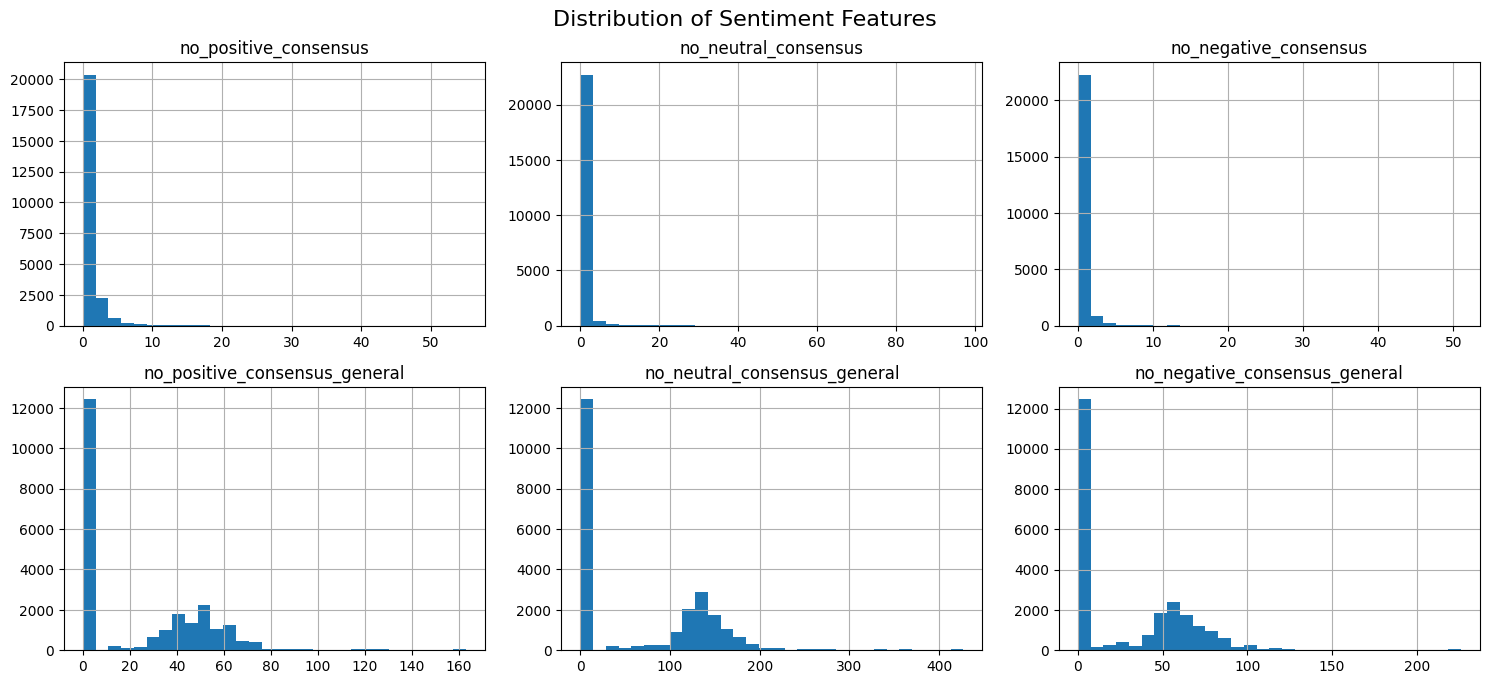

In [19]:
sentiment_cols = [
    "no_positive_consensus", "no_neutral_consensus", "no_negative_consensus",
    "no_positive_consensus_general", "no_neutral_consensus_general", "no_negative_consensus_general"
]

# Histograms
df[sentiment_cols].hist(bins=30, figsize=(15, 10), layout=(3, 3))
plt.suptitle("Distribution of Sentiment Features", fontsize=16)
plt.tight_layout()
plt.show()


Top 10 most mentioned tickers:
 ticker
XYZ     260
AAPL    260
ACHR    260
RKLB    260
RKT     260
RSI     260
SBUX    260
SCI     260
SGHC    260
SMCI    260
Name: count, dtype: int64


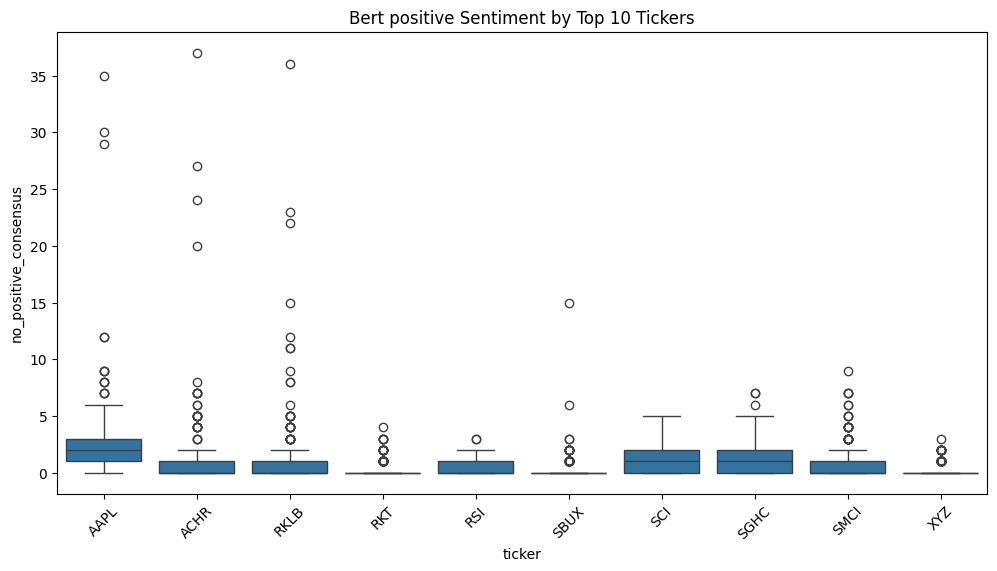

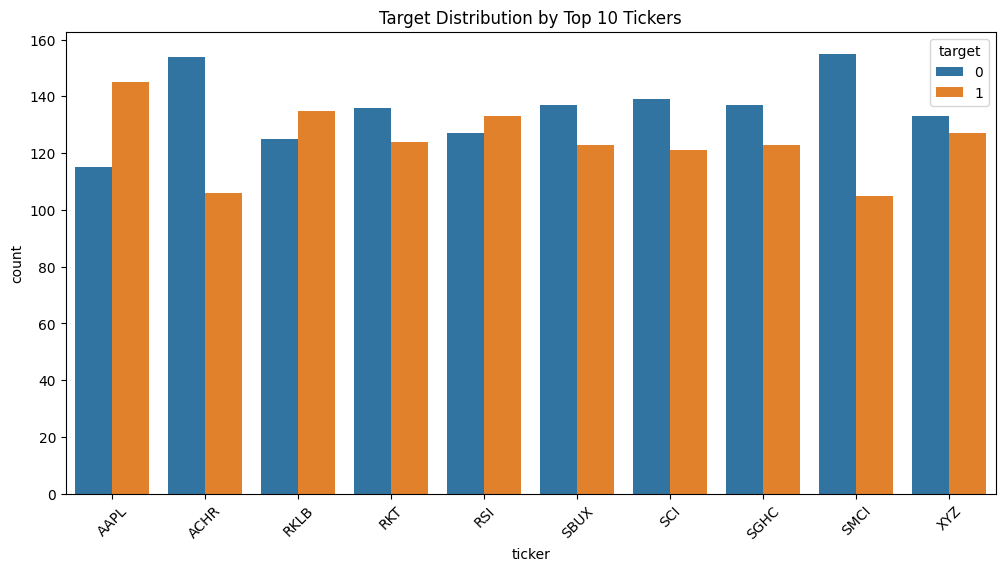

In [21]:
# Top 10 most mentioned tickers
top_tickers = df['ticker'].value_counts().head(10)
print("Top 10 most mentioned tickers:\n", top_tickers)

# Plot average vader score by ticker (top tickers only)
top_df = df[df['ticker'].isin(top_tickers.index)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=top_df, x='ticker', y='no_positive_consensus')
plt.title("Bert positive Sentiment by Top 10 Tickers")
plt.xticks(rotation=45)
plt.show()

# Distribution of target by ticker
plt.figure(figsize=(12, 6))
sns.countplot(data=top_df, x='ticker', hue='target')
plt.title("Target Distribution by Top 10 Tickers")
plt.xticks(rotation=45)
plt.show()


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
comments = pd.read_csv("wsb_arcticshift_comments_with_sentiment_corrected.csv")
submissions = pd.read_csv("wsb_arcticshift_submissions_with_sentiment_corrected.csv")

# Plot distributions
plt.figure(figsize=(14, 6))

# VADER Distribution
plt.subplot(1, 2, 1)
sns.histplot(comments["vader_score"], bins=30, kde=True, color="steelblue", label="Comments", alpha=0.6)
sns.histplot(submissions["vader_score"], bins=30, kde=True, color="orange", label="Submissions", alpha=0.6)
plt.title("VADER Sentiment Distribution")
plt.xlabel("VADER Score")
plt.ylabel("Frequency")
plt.legend()

# BERT Sentiment Distribution
plt.subplot(1, 2, 2)
sns.histplot(comments["bert_sentiment_score"], bins=30, kde=True, color="steelblue", label="Comments", alpha=0.6)
sns.histplot(submissions["bert_sentiment_score"], bins=30, kde=True, color="orange", label="Submissions", alpha=0.6)
plt.title("FinBERT Sentiment Distribution")
plt.xlabel("BERT Sentiment Score")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()


KeyError: 'finbert_positive'

In [29]:
import pandas as pd

# Load one of the datasets
df = pd.read_csv("wsb_arcticshift_submissions_with_sentiment_corrected.csv")  # or use the comments file

# Sample 10 random rows
sampled = df[["text", "vader_score", "bert_sentiment_score"]].sample(10, random_state=42)

# Display full text without truncation
pd.set_option('display.max_colwidth', None)
print(sampled)

sampled.to_csv("random_sample10.csv", index=False)


/var/folders/zn/s6zzv27j6jxfgw75rmyw03_r0000gn/T/ipykernel_6742/1056955863.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=flair_counts.values, y=flair_counts.index, palette="viridis")


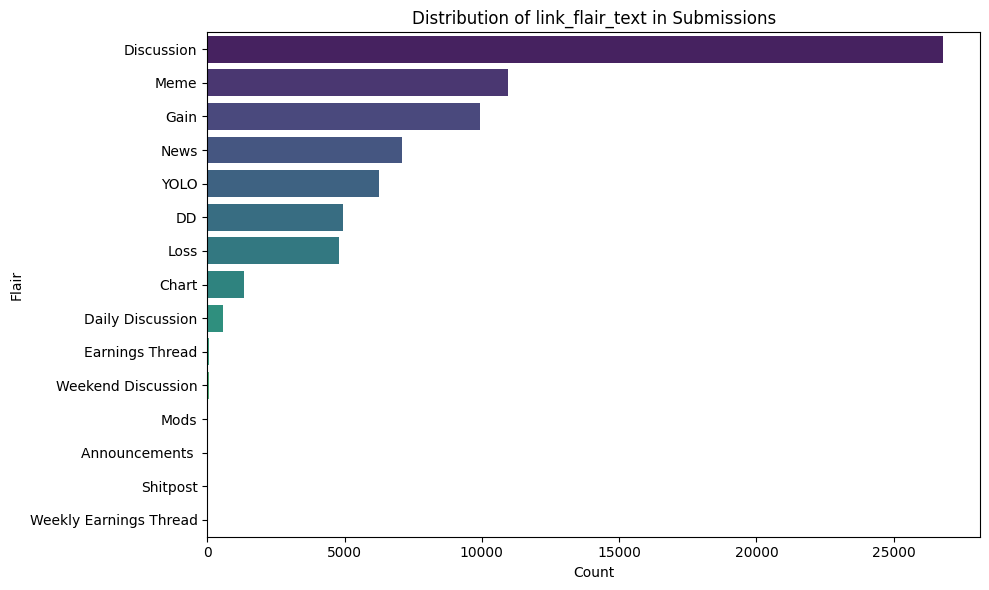

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load submissions CSV
df = pd.read_csv("wsb_arcticshift_submissions_with_sentiment_corrected.csv")

# Drop missing flairs (optional)
df_flair = df.dropna(subset=["link_flair_text"])

# Count distribution
flair_counts = df_flair["link_flair_text"].value_counts()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=flair_counts.values, y=flair_counts.index, palette="viridis")
plt.title("Distribution of link_flair_text in Submissions")
plt.xlabel("Count")
plt.ylabel("Flair")
plt.tight_layout()
plt.show()


In [15]:
import pandas as pd

# Load dataset
df = pd.read_csv("final_stock_sentiment_dataset2.csv")

# List of numeric features
numeric_features = [
    "no_positive_consensus",
    "no_neutral_consensus",
    "no_negative_consensus",
    "like_score_positive",
    "like_score_negative",
    "avg_num_comments",
    "number_of_mentions",
    "no_positive_consensus_general",
    "no_neutral_consensus_general",
    "no_negative_consensus_general",
]

# Filter to only numeric columns of interest
df_numeric = df[numeric_features]

# Calculate mean, min, and max
summary_stats = pd.DataFrame({
    "mean": df_numeric.mean(),
    "min": df_numeric.min(),
    "max": df_numeric.max()
})

# Print results rounded to 3 decimals
print(summary_stats.round(3))

# Optional: save to CSV
# summary_stats.to_csv("numeric_summary_stats.csv")


                                  mean   min      max
no_positive_consensus            1.598   0.0     55.0
no_neutral_consensus             1.671   0.0     97.0
no_negative_consensus            0.809   0.0     51.0
like_score_positive            173.246   0.0  30219.0
like_score_negative            148.478   0.0  33634.0
avg_num_comments                42.439   0.0   4199.0
number_of_mentions               4.078   1.0    169.0
no_positive_consensus_general   50.705   9.0    163.0
no_neutral_consensus_general   139.769  31.0    427.0
no_negative_consensus_general   60.853   7.0    226.0
